In [5]:
from utils import balance_sample

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon, mannwhitneyu

# Load Data

In [6]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [8]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
df.to_csv('all_markers.csv')

In [98]:
df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
              .query("preproc == 'subtracted'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events', 'preproc', 'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

markers = ['wSMI', 'p_e', 'k', 'b', 'b_n', 'g', 'g_n', 't', 't_n',
       'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']

# By Subject Univariate analyses 

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [99]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_mind.drop(markers, axis=1).columns})

df_mind = (df_mind
    .groupby(['mind2', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
)

df_mind.columns = df_mind.columns.map("_".join)
df_mind  = df_mind.rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_first':'mind2'})
df_mind = balance_sample(df_mind, 'participant', 'mind2', levels = 2).drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also

AUC wSMI_mean = 0.47916666666666674 WilcoxonResult(statistic=39.0, pvalue=1.0)
AUC wSMI_std = 0.4722222222222222 WilcoxonResult(statistic=28.0, pvalue=0.423828125)
AUC p_e_mean = 0.4930555555555556 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC p_e_std = 0.4097222222222222 WilcoxonResult(statistic=24.0, pvalue=0.26611328125)
AUC k_mean = 0.48611111111111116 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC k_std = 0.6041666666666666 WilcoxonResult(statistic=35.0, pvalue=0.791015625)
AUC b_mean = 0.5069444444444444 WilcoxonResult(statistic=39.0, pvalue=1.0)
AUC b_std = 0.22916666666666669 WilcoxonResult(statistic=10.0, pvalue=0.02099609375)
AUC b_n_mean = 0.5069444444444444 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC b_n_std = 0.5347222222222222 WilcoxonResult(statistic=36.0, pvalue=0.85009765625)
AUC g_mean = 0.4930555555555556 WilcoxonResult(statistic=37.0, pvalue=0.90966796875)
AUC g_std = 0.36111111111111116 WilcoxonResult(statistic=25.0, pvalue=0.3012695

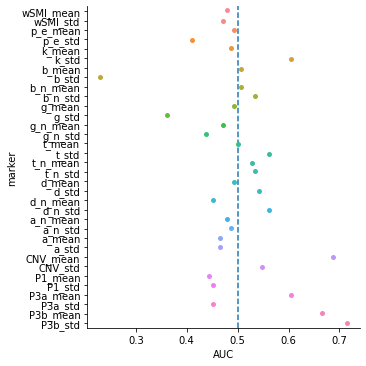

In [100]:
AUC = []
significants = []

for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

subject_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = subject_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.6597222222222222
AUC wSMI_std = 0.6458333333333333
AUC p_e_mean = 0.611111111111111
AUC p_e_std = 0.6666666666666667
AUC k_mean = 0.5833333333333334
AUC k_std = 0.7430555555555556
AUC b_mean = 0.5763888888888888
AUC b_std = 0.20833333333333334
AUC b_n_mean = 0.7777777777777778
AUC b_n_std = 0.20833333333333334
AUC g_mean = 0.607638888888889
AUC g_std = 0.5
AUC g_n_mean = 0.5868055555555556
AUC g_n_std = 0.6388888888888888
AUC t_mean = 0.5763888888888888
AUC t_std = 0.7291666666666666
AUC t_n_mean = 0.6736111111111112
AUC t_n_std = 0.6458333333333334
AUC d_mean = 0.5694444444444444
AUC d_std = 0.7361111111111112
AUC d_n_mean = 0.6388888888888888
AUC d_n_std = 0.6111111111111112
AUC a_n_mean = 0.5694444444444444
AUC a_n_std = 0.7152777777777778
AUC a_mean = 0.5833333333333334
AUC a_std = 0.5902777777777778
AUC CNV_mean = 0.3125
AUC CNV_std = 0.6597222222222222
AUC P1_mean = 0.7881944444444444
AUC P1_std = 0.6458333333333334
AUC P3a_mean = 0.7083333333333334
AUC P3a_std 

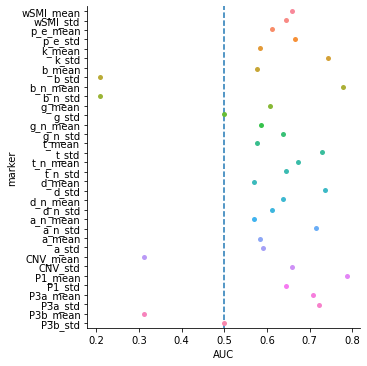

In [105]:
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [106]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind', 'participant']).filter(lambda x: len(x) > 7) #min nbr of trials
)

agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_mw.drop(markers, axis=1).columns})

df_mw = (df_mw
    .groupby(['mind', 'participant'], as_index = False).agg(agg_dict)
)
df_mw = balance_sample(df_mw, 'participant', 'mind', levels = 2).drop(['participant', 'probe','segment'], axis = 1) 


AUC wSMI = 0.55078125 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC p_e = 0.484375 WilcoxonResult(statistic=44.0, pvalue=0.231201171875)
AUC k = 0.5390625 WilcoxonResult(statistic=53.0, pvalue=0.4637451171875)
AUC b = 0.5078125 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC b_n = 0.515625 WilcoxonResult(statistic=59.0, pvalue=0.668548583984375)
AUC g = 0.515625 WilcoxonResult(statistic=54.0, pvalue=0.49542236328125)
AUC g_n = 0.55078125 WilcoxonResult(statistic=47.0, pvalue=0.2978515625)
AUC t = 0.48046875 WilcoxonResult(statistic=57.0, pvalue=0.596588134765625)
AUC t_n = 0.48828125 WilcoxonResult(statistic=68.0, pvalue=1.0)
AUC d = 0.48046875 WilcoxonResult(statistic=61.0, pvalue=0.743560791015625)
AUC d_n = 0.44140625 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC a_n = 0.5 WilcoxonResult(statistic=57.0, pvalue=0.596588134765625)
AUC a = 0.4609375 WilcoxonResult(statistic=56.0, pvalue=0.5618896484375)
AUC CNV = 0.55078125 WilcoxonResult(statist

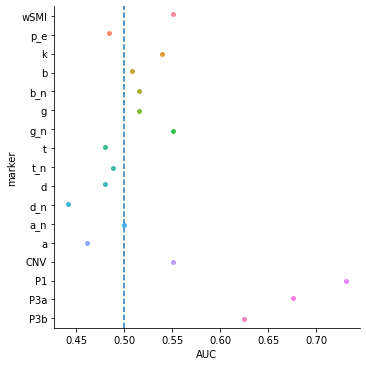

In [107]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{wilcoxon(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
subject_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')


sns.catplot(x = 'AUC', y = 'marker', data = subject_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.6484375
AUC p_e = 0.68359375
AUC k = 0.5625
AUC b = 0.5703125
AUC b_n = 0.60546875
AUC g = 0.5859375
AUC g_n = 0.5625
AUC t = 0.59375
AUC t_n = 0.607421875
AUC d = 0.60546875
AUC d_n = 0.58984375
AUC a_n = 0.599609375
AUC a = 0.62109375
AUC CNV = 0.71875
AUC P1 = 0.31640625
AUC P3a = 0.29296875
AUC P3b = 0.6796875
Index(['dMW', 'sMW'], dtype='object')


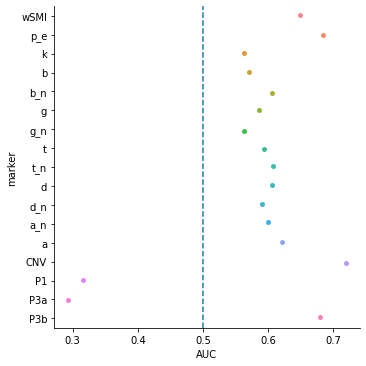

In [108]:
AUC = []
for i in df_mw.drop('mind', axis = 1).columns:
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Segment Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [129]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind  = (df_mind
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment', 'mind2_':'mind2'})
            .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) 
           )

AUC wSMI_mean = 0.5426829268292682 MannwhitneyuResult(statistic=3525.0, pvalue=0.16496727199686728)
AUC wSMI_std = 0.4807991696938246 MannwhitneyuResult(statistic=3706.0, pvalue=0.330893706671614)
AUC p_e_mean = 0.45524130773222626 MannwhitneyuResult(statistic=3509.0, pvalue=0.1534620293191562)
AUC p_e_std = 0.5311364815775818 MannwhitneyuResult(statistic=3614.0, pvalue=0.238760662076057)
AUC k_mean = 0.4608199273482097 MannwhitneyuResult(statistic=3552.0, pvalue=0.18561487819637795)
AUC k_std = 0.5880254281266216 MannwhitneyuResult(statistic=3175.5, pvalue=0.022174713595810497)
AUC b_mean = 0.425531914893617 MannwhitneyuResult(statistic=3280.0, pvalue=0.04448537842954947)
AUC b_std = 0.4708095485210171 MannwhitneyuResult(statistic=3629.0, pvalue=0.25276668357256504)
AUC b_n_mean = 0.4316294758692268 MannwhitneyuResult(statistic=3327.0, pvalue=0.05920735222512055)
AUC b_n_std = 0.5281525687597302 MannwhitneyuResult(statistic=3637.0, pvalue=0.2604097109316945)
AUC g_mean = 0.45731707317

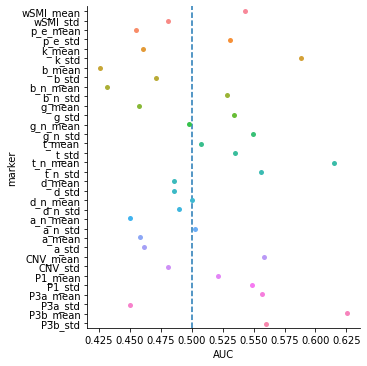

In [130]:
significants = []
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append([i, auc])
        
segment_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])
significants_mind = pd.DataFrame(significants, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants_mw.marker.values}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.5315256875973015
AUC wSMI_std = 0.5509859885832901
AUC p_e_mean = 0.5755059678256357
AUC p_e_std = 0.6065775817332643
AUC k_mean = 0.55118059159315
AUC k_std = 0.3445770627919045
AUC b_mean = 0.43850544888427606
AUC b_std = 0.3894654903995849
AUC b_n_mean = 0.4150233523611832
AUC b_n_std = 0.39711987545407373
AUC g_mean = 0.5818629994810587
AUC g_std = 0.5808899844317592
AUC g_n_mean = 0.5764141152049819
AUC g_n_std = 0.3847950181629476
AUC t_mean = 0.5574078879086664
AUC t_std = 0.5516995329527764
AUC t_n_mean = 0.35871821484172295
AUC t_n_std = 0.34950700570835497
AUC d_mean = 0.5408666320705761
AUC d_std = 0.5426829268292683
AUC d_n_mean = 0.40749870264660093
AUC d_n_std = 0.48780487804878053
AUC a_n_mean = 0.5783601453035807
AUC a_n_std = 0.5726517903476906
AUC a_mean = 0.4263103269330566
AUC a_std = 0.5402179553710431
AUC CNV_mean = 0.4332511676180592
AUC CNV_std = 0.546574987026466
AUC P1_mean = 0.42631032693305654
AUC P1_std = 0.5783601453035806
AUC P3a_mean = 

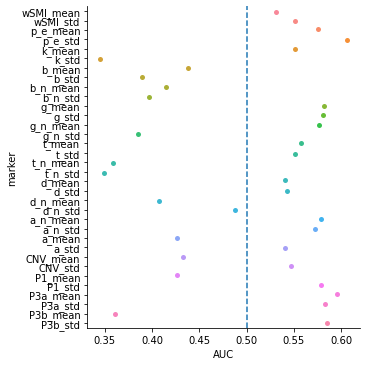

In [111]:
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI_mean = 0.4696784116741632
AUC wSMI_std = 0.42075575910936164
AUC p_e_mean = 0.44894838081601274
AUC p_e_std = 0.5547618562511948
AUC k_mean = 0.43712593351647855
AUC k_std = 0.629371494179683
AUC b_mean = 0.5432342732541369
AUC b_std = 0.5327760138198774
AUC b_n_mean = 0.5261034470078122
AUC b_n_std = 0.5175704646622968
AUC g_mean = 0.48300683464425714
AUC g_std = 0.46618054245428103
AUC g_n_mean = 0.4481395522294354
AUC g_n_std = 0.5451698809614164
AUC t_mean = 0.45410384019133176
AUC t_std = 0.4169359124742285
AUC t_n_mean = 0.5935250204494433
AUC t_n_std = 0.598528378511612
AUC d_mean = 0.43968323706425744
AUC d_std = 0.4285644404421792
AUC d_n_mean = 0.5342911412314024
AUC d_n_std = 0.4388125687006077
AUC a_n_mean = 0.4602850753252737
AUC a_n_std = 0.47432855076646135
AUC a_mean = 0.5264308575431231
AUC a_std = 0.43085125381119516
AUC CNV_mean = 0.5432236315864944
AUC CNV_std = 0.4470456397392767
AUC P1_mean = 0.4771094371348992
AUC P1_std = 0.4462353257150594
AUC P3a_mean

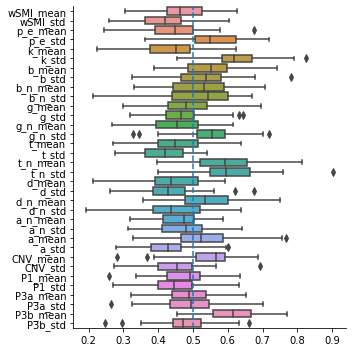

In [112]:
AUC = pd.DataFrame()
for i in df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

In [ ]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [131]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )

AUC wSMI_mean = 0.46748251748251746 MannwhitneyuResult(statistic=33425.0, pvalue=0.09688428493426793)
AUC wSMI_std = 0.4836783216783217 MannwhitneyuResult(statistic=34583.0, pvalue=0.25715816083766774)
AUC p_e_mean = 0.37370629370629366 MannwhitneyuResult(statistic=26720.0, pvalue=2.2329998043768022e-07)
AUC p_e_std = 0.5151468531468532 MannwhitneyuResult(statistic=34667.0, pvalue=0.2725325727848976)
AUC k_mean = 0.5012797202797203 MannwhitneyuResult(statistic=35658.5, pvalue=0.47971311694161795)
AUC k_std = 0.5130419580419581 MannwhitneyuResult(statistic=34817.5, pvalue=0.3011713086159559)
AUC b_mean = 0.4229370629370629 MannwhitneyuResult(statistic=30240.0, pvalue=0.001034708988537611)
AUC b_std = 0.4616643356643356 MannwhitneyuResult(statistic=33009.0, pvalue=0.062751859734307)
AUC b_n_mean = 0.48141258741258736 MannwhitneyuResult(statistic=34421.0, pvalue=0.2288323928485717)
AUC b_n_std = 0.4746013986013986 MannwhitneyuResult(statistic=33934.0, pvalue=0.15506368106423052)
AUC g_mea

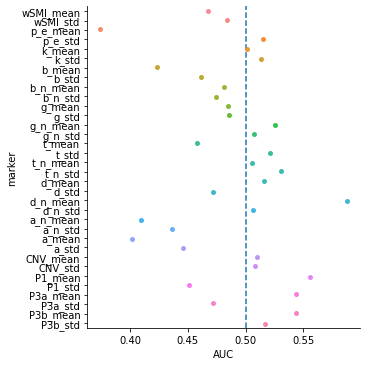

In [132]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append([i, auc])
segment_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])
significants_mw = pd.DataFrame(significants, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants_mw.marker.values}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
AUC = pd.DataFrame()
for i in df_mw.drop('mind', axis = 1).columns:
    
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# By Trial Univariate analyses

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [ ]:
agg_dict = {k:'mean' for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers
    .query("probe == 'PC'")
#     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

In [ ]:
significants = []
AUC = []
for i in df_mind.drop('mind2', axis = 1).columns:
    ot = df_mind.query("mind2 == 'on-task'")[i]
    mw = df_mind.query("mind2 == 'mw'")[i]
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = ot, y = mw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = ot, y = mw).pvalue < 0.05:
        significants.append(i)

print(f'List of significant markers: {significants}')

trial_mind_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = segment_mind_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
AUC = []
for i in  df_mind.drop('mind2', axis = 1).columns:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
n_estimators = 2000
AUC = pd.DataFrame()
for i in  df_mind.drop('mind2', axis = 1).columns:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

In [ ]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [ ]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe', 'segment'], axis = 1)
)

In [ ]:
AUC = []
significants = []
for i in df_mw.drop('mind', axis = 1).columns:
    smw = df_mw.query("mind == 'sMW'")[i]
    dmw = df_mw.query("mind == 'dMW'")[i]
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}', f'{mannwhitneyu(x = smw, y = dmw)}')
    AUC.append([i, auc])
    if mannwhitneyu(x = smw, y = dmw).pvalue < 0.05:
        significants.append(i)
trial_mw_roc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

print(f'List of significant markers: {significants}')

sns.catplot(x = 'AUC', y = 'marker', data = segment_mw_roc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [ ]:
AUC = pd.DataFrame()
for i in df_mw.drop('mind', axis = 1).columns:
    
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Plots

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

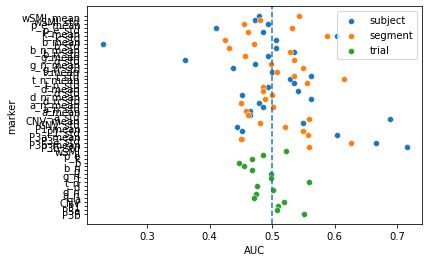

In [135]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mind_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mind_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

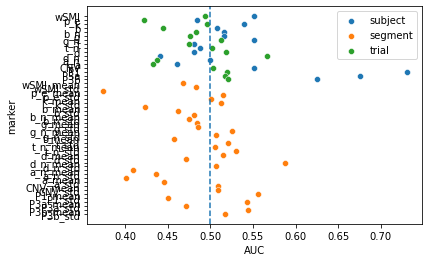

In [136]:
sns.scatterplot(x = 'AUC', y = 'marker', data = subject_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = segment_mw_roc)
sns.scatterplot(x = 'AUC', y = 'marker', data = trial_mw_roc)
plt.legend(['subject','segment', 'trial'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

## Comparison of significan markers for Mind and Mw

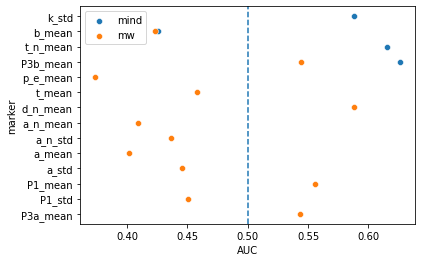

In [134]:
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mind )
sns.scatterplot(x = 'AUC', y = 'marker', data = significants_mw )
plt.legend(['mind','mw'])
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()